This NB demonstrates the xcube **SMOS L2C data store `smos`**.

In [1]:
import json

from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store

# Utilities for notebook visualization
import shapely.geometry
import IPython.display
from IPython.display import JSON
import matplotlib.pyplot as plt

In [2]:
#import dask.distributed
#dask.distributed.Client(processes=False, n_workers=4)

Which data stores are available? The data store `smos` should be among them!

In [3]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

Which parameters are supported by the `smos` data store?

In [4]:
get_data_store_params_schema('smos')

Create a store instance. Load our CreoDIAS credentials first.

In [5]:
with open("creodias-credentials.json") as f:
    credentials = json.load(f)

In [6]:
store = new_data_store('smos', **credentials)

Which parameters are supported if I use the store to open a SMOS datacube?

In [7]:
store.get_open_data_params_schema()

Which dataset types are supported by the `smos` data store?

In [8]:
JSON(store.list_data_ids())

<IPython.core.display.JSON object>

In [9]:
store.get_data_opener_ids()

('dataset:zarr:smos', 'mldataset:zarr:smos', 'dsiter:zarr:smos')

Lets try the opener `"mldataset:zarr:smos"` that will provide an xcube multi-resolution dataset:

In [10]:
mlds = store.open_data("SMOS-L2C-SM", 
                       opener_id="mldataset:zarr:smos",
                       time_range=("2022-01-01", "2022-01-06"),
                       l2_product_cache_size=128)

In [11]:
for level in range(mlds.num_levels):
    ds = mlds.get_dataset(level)
    print(f"Level {level}: {ds.dims}")

Level 0: Frozen({'time': 143, 'lat': 4032, 'lon': 8192, 'bnds': 2})
Level 1: Frozen({'time': 143, 'lat': 2016, 'lon': 4096, 'bnds': 2})
Level 2: Frozen({'time': 143, 'lat': 1008, 'lon': 2048, 'bnds': 2})
Level 3: Frozen({'time': 143, 'lat': 504, 'lon': 1024, 'bnds': 2})
Level 4: Frozen({'time': 143, 'lat': 252, 'lon': 512, 'bnds': 2})


In [12]:
ds = mlds.get_dataset(0)
ds

<xarray.Dataset>
Dimensions:            (time: 143, lat: 4032, lon: 8192, bnds: 2)
Coordinates:
  * lat                (lat) float64 88.57 88.53 88.48 ... -88.48 -88.53 -88.57
  * lon                (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time               (time) datetime64[ns] 2022-01-01T00:43:53.500000 ... 2...
    time_bnds          (time, bnds) datetime64[ns] dask.array<chunksize=(143, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    Chi_2              (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Chi_2_P            (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    N_RFI_X            (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    N_RFI_Y            (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    RFI_Prob           (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Soil_Moisture      (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Soil_Moisture_DQX  (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>

In [13]:
ds.Soil_Moisture

<xarray.DataArray 'Soil_Moisture' (time: 143, lat: 4032, lon: 8192)>
dask.array<open_dataset-Soil_Moisture, shape=(143, 4032, 8192), dtype=float32, chunksize=(1, 4032, 8192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 88.57 88.53 88.48 88.44 ... -88.48 -88.53 -88.57
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 2022-01-01T00:43:53.500000 ... 2022-01-05T...
Attributes:
    units:    m3 m-3

In [14]:
#ds.Soil_Moisture.data.visualize()

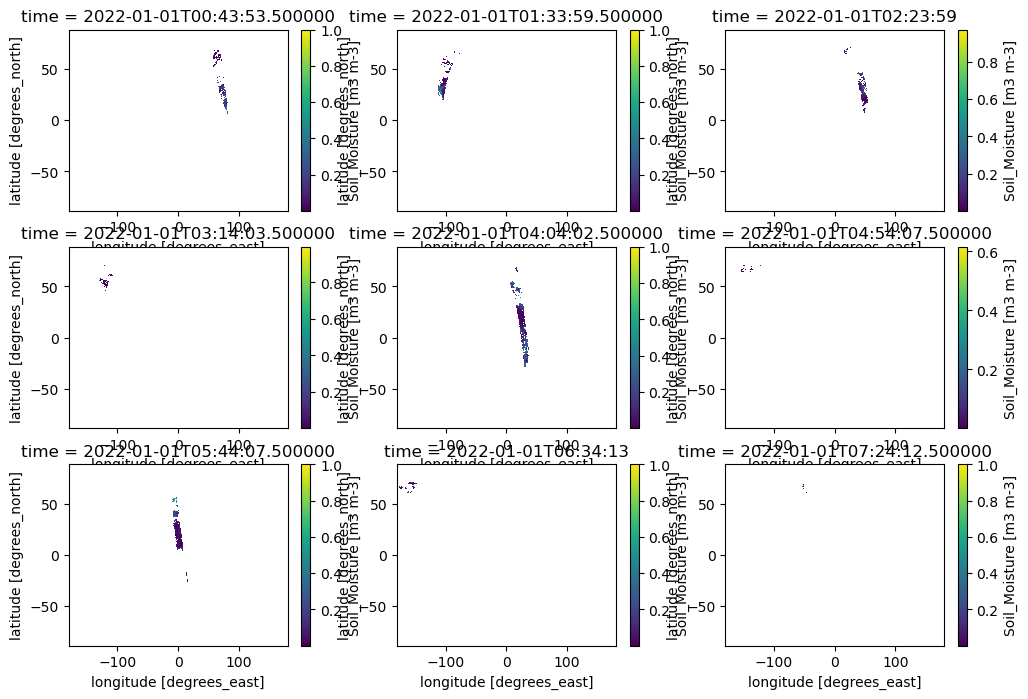

In [15]:
from itertools import chain
f, axes = plt.subplots(3, 3, figsize=(12, 8))
for index, ax in enumerate(chain(*axes)):
    ds.Soil_Moisture.isel(time=index).plot.imshow(ax=ax)

In [16]:
# %%timeit -n 1 -r 1
result = ds.Soil_Moisture.mean("time").compute()

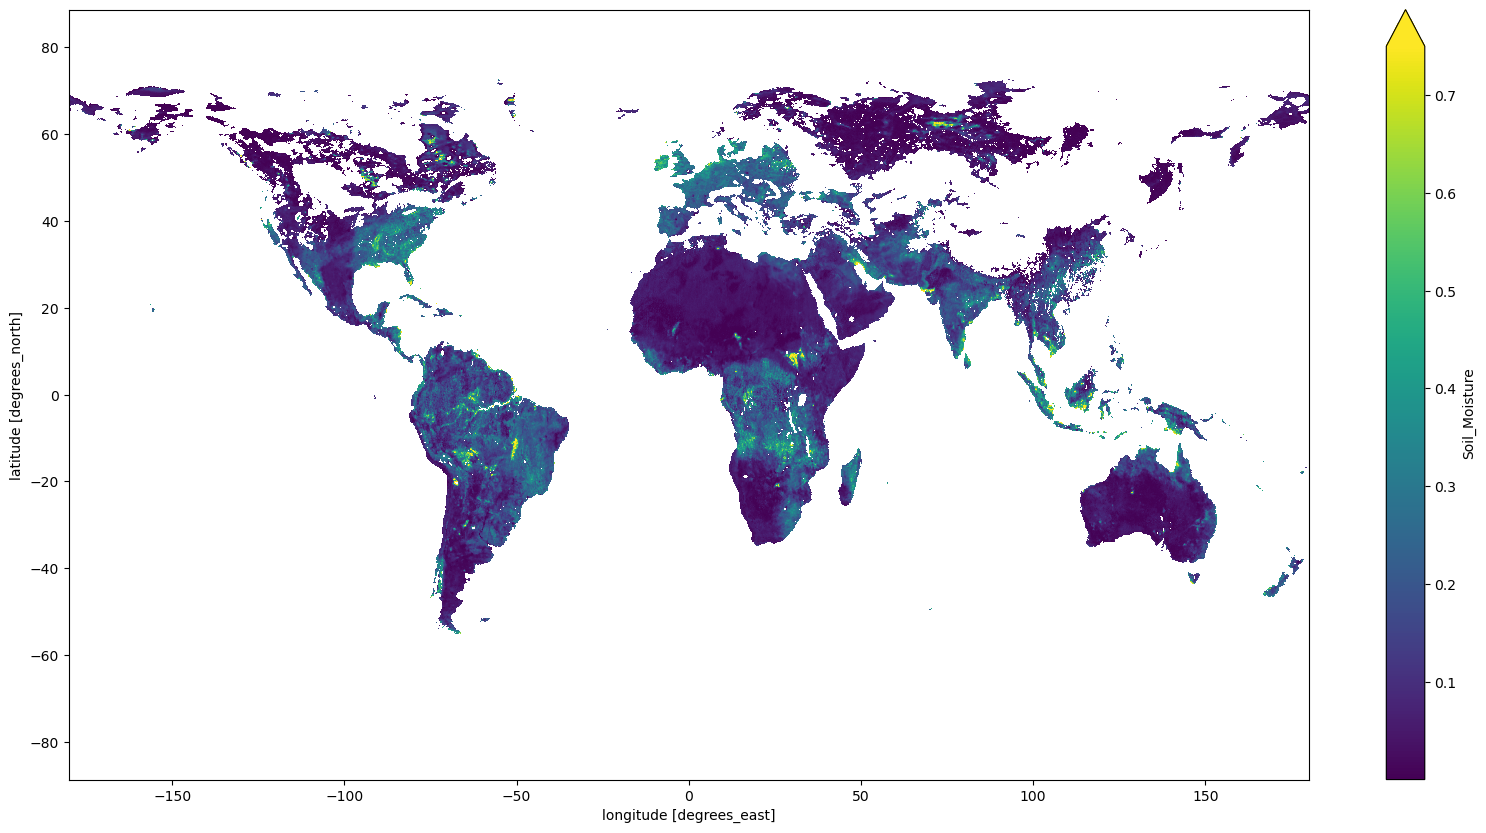

In [17]:
result.plot.imshow(figsize=(20, 10), vmax=0.75)

In [18]:
#for name, var in ds.variables.items():
#    display(name, var.encoding)

In [19]:
ds_rechunked = ds.chunk(dict(time=1, lat=4032 // 4, lon=8192 // 8))
#ds_rechunked = ds_rechunked.drop('time_bnds')
for v in ds_rechunked.variables.values():
    del v.encoding["chunks"]
    del v.encoding["preferred_chunks"]
    v.encoding["write_empty_chunks"] = False

In [20]:
#ds_rechunked.to_zarr("smos.zarr", mode="w")

In [21]:
from xcube.webapi.viewer import Viewer
import xarray as xr

In [22]:
viewer = Viewer()

In [23]:
viewer.add_dataset(xr.open_zarr("smos.zarr"), title="SMOS-L2C-SM")

'2b383b90-e194-4efa-8cea-57cce94d5a63'

In [24]:
viewer.show()

404 GET /viewer/config/config.json (127.0.0.1): xcube viewer has not been been configured
404 GET /viewer/config/config.json (127.0.0.1) 756.27ms
